# BTC Stochastic + Mining Cost Models/Backtest 

Implemented two models:
1. **Mining Cost model** tuned to beat BTC buy-and-hold by a small Sharpe margin.
2. **OU stochastic mean-reversion model** with simple parameter search.


In [32]:
import numpy as np
import pandas as pd
from pathlib import Path
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

TRADING_DAYS = 365


In [33]:
def _clean_numeric_series(s: pd.Series) -> pd.Series:
    """Convert strings with commas/%/$ to float when possible."""
    if s.dtype == "O":
        s2 = (
            s.astype(str)
             .str.replace(",", "", regex=False)
             .str.replace("$", "", regex=False)
             .str.replace("%", "", regex=False)
             .str.strip()
        )
        return pd.to_numeric(s2, errors="coerce")
    return pd.to_numeric(s, errors="coerce")

def _find_first_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    cols = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols:
            return cols[cand.lower()]
    return None

def read_price_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)

    # 1) date column
    date_col = _find_first_col(df, ["End", "Start", "Date", "timestamp", "Datetime", "Time", "time"])
    if date_col is None:
        raise ValueError(f"Cannot find a date column in {path.name}. Columns: {list(df.columns)}")

    df[date_col] = pd.to_datetime(df[date_col], errors="coerce", infer_datetime_format=True)
    df = df.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)

    # 2) normalize column names we care about
    # some files use Price instead of Close (IBIT)
    close_col = _find_first_col(df, ["Close", "Price", "Adj Close", "AdjClose", "close", "price"])
    if close_col is None:
        raise ValueError(f"Cannot find a close/price column in {path.name}. Columns: {list(df.columns)}")

    # convert key numeric columns if present
    for c in df.columns:
        df[c] = _clean_numeric_series(df[c]) if df[c].dtype == "O" else df[c]

    # unify to standard OHLC if missing
    if "Close" not in df.columns:
        df["Close"] = df[close_col].astype(float)

    # if Open/High/Low exist, clean them too
    for c in ["Open", "High", "Low", "Volume", "Market Cap", "CVol"]:
        if c in df.columns:
            df[c] = _clean_numeric_series(df[c])

    return df

def read_mining_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)

    # find a timestamp-like column
    ts_col = _find_first_col(df, ["timestamp", "Timestamp", "date", "Date", "time", "Time"])
    if ts_col is None:
        # your mining file may have multiple timestamp cols; brute force fallback
        ts_candidates = [c for c in df.columns if str(c).lower() == "timestamp"]
        if ts_candidates:
            ts_col = ts_candidates[0]
        else:
            raise ValueError(f"No timestamp column found in {path.name}. Columns: {list(df.columns)}")

    df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce", infer_datetime_format=True)
    df = df.dropna(subset=[ts_col]).sort_values(ts_col).set_index(ts_col)

    # drop duplicate columns + unnamed
    df = df.loc[:, ~df.columns.duplicated()]
    df = df.loc[:, [c for c in df.columns if not str(c).lower().startswith("unnamed")]]

    # clean numerics where possible
    for c in df.columns:
        df[c] = _clean_numeric_series(df[c])

    return df


In [34]:
from pathlib import Path
import pandas as pd

# --- USE DIRECT ABSOLUTE PATHS ---
FILES = {
    "btc": Path("/Users/samgeng14/PycharmProjects/LunaExchange/BTC.csv"),
    "ibit": Path("/Users/samgeng14/PycharmProjects/LunaExchange/IBIT.csv"),
    "etha": Path("/Users/samgeng14/PycharmProjects/LunaExchange/ETHA.csv"),
    "btc_mining": Path("/Users/samgeng14/PycharmProjects/LunaExchange/BTC_Mining_Cost.csv"),
}

def read_price_csv(path: Path):
    df = pd.read_csv(path)

    # find date column
    for col in ["Date", "End", "Start", "timestamp", "Timestamp"]:
        if col in df.columns:
            date_col = col
            break
    else:
        raise ValueError(f"No date column found in {path.name}. Columns: {list(df.columns)}")

    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)

    # IBIT uses Price instead of Close
    if "Close" not in df.columns:
        if "Price" in df.columns:
            df["Close"] = df["Price"]
        else:
            raise ValueError(f"No Close/Price column found in {path.name}")

    # clean numbers
    for c in df.columns:
        if df[c].dtype == "O":
            df[c] = (
                df[c]
                .astype(str)
                .str.replace(",", "", regex=False)
                .str.replace("$", "", regex=False)
                .str.replace("%", "", regex=False)
            )
            df[c] = pd.to_numeric(df[c], errors="ignore")

    return df


def read_mining_csv(path: Path):
    df = pd.read_csv(path)

    for col in ["timestamp", "Timestamp", "Date", "date"]:
        if col in df.columns:
            ts_col = col
            break
    else:
        raise ValueError(f"No timestamp column found in {path.name}. Columns: {list(df.columns)}")

    df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
    df = df.dropna(subset=[ts_col]).sort_values(ts_col).set_index(ts_col)

    # clean numeric columns
    for c in df.columns:
        if df[c].dtype == "O":
            df[c] = (
                df[c]
                .astype(str)
                .str.replace(",", "", regex=False)
                .str.replace("$", "", regex=False)
                .str.replace("%", "", regex=False)
            )
            df[c] = pd.to_numeric(df[c], errors="ignore")

    return df


btc = read_price_csv(FILES["btc"])
ibit = read_price_csv(FILES["ibit"])
etha = read_price_csv(FILES["etha"])
btc_mining_raw = read_mining_csv(FILES["btc_mining"])

display(btc.tail())
display(ibit.tail())
display(etha.tail())
display(btc_mining_raw.tail())


,Start,Open,High,Low,Close,Volume,Market Cap
End,,,,,,,
2026-02-06,2026-02-05,"73,093.1400","73,265.4800","62,602.5800","62,951.5100","111,881,683,696.0906","1,380,141,010,532.0801"
2026-02-07,2026-02-06,"62,385.7900","71,671.1300","60,126.4000","70,556.8800","169,586,922,941.5493","1,341,561,092,325.8416"
2026-02-08,2026-02-07,"70,306.9600","71,521.6400","67,627.6900","69,341.9600","106,553,752,024.3519","1,386,138,001,246.8779"
2026-02-09,2026-02-08,"69,351.8100","71,901.3600","69,000.3200","70,580.1000","61,974,296,039.6411","1,405,796,272,826.9128"
2026-02-10,2026-02-09,"70,427.9600","71,362.1900","68,439.0400","70,162.1000","59,278,579,293.8223","1,401,468,045,245.5784"


,Price,CVol,% Change,Open,Low,High,NAV,Total Return (Gross),% Return,Cumulative Return %,Close
Date,,,,,,,,,,,
2025-09-18,66.7500,38481190,1.6400,66.7300,66.4800,67.0400,66.7300,66.7500,1.6400,167.3200,66.7500
2025-09-19,65.3700,32989380,-2.0700,66.0100,65.3400,66.2000,65.4600,65.3700,-2.0700,161.7900,65.3700
2025-09-22,63.6500,42504047,-2.6300,64.1800,63.5800,64.4600,63.8200,63.6500,-2.6300,154.9100,63.6500
2025-09-23,63.4100,40144960,-0.3800,64.1600,63.3300,64.3900,63.4500,63.4100,-0.3800,153.9400,63.4100
2025-09-24,64.6000,18834733,1.8800,64.2000,64.0700,64.7500,NaN,64.6000,1.8800,158.7100,64.6000


,Start,Open,High,Low,Close,Volume,Market Cap
End,,,,,,,
2026-02-06,2026-02-05,"2,140.0039","2,162.5775","1,824.6902","1,824.6902","69,776,240,537.3484","245,558,850,362.4878"
2026-02-07,2026-02-06,"1,813.4763","2,081.6370","1,764.2290","2,061.3085","92,425,381,373.6620","236,448,851,363.2113"
2026-02-08,2026-02-07,"2,057.8220","2,112.6386","2,000.3362","2,090.9076","63,722,166,673.9895","248,335,342,546.8397"
2026-02-09,2026-02-08,"2,089.7259","2,137.0967","2,070.9122","2,096.1317","42,392,025,387.3868","253,493,589,636.0070"
2026-02-10,2026-02-09,"2,090.9629","2,139.4647","2,012.4693","2,105.0785","32,203,174,394.6690","250,719,752,461.8885"


,BTC: Circulating Supply,timestamp.1,BTC: Difficulty,timestamp.2,Difficulty Regression Model,timestamp.3,BTC: Price,timestamp.4,Difficulty Multiple (Difficulty Price > Spot Price),timestamp.5,Difficulty Multiple (Difficulty Price < Spot Price),timestamp.6,---
timestamp,,,,,,,,,,,,,
2026-01-07,"19,972,924.1700",2026-01-07 00:00:00,"636,765,124,765,471,427,526,656.0000",2026-01-07 00:00:00,"39,215.6793",2026-01-07 00:00:00,"91,309.5007",2026-01-07 00:00:00,0.0000,2026-01-07 00:00:00,-0.5572,2026-01-07 00:00:00,8
2026-01-08,"19,973,336.6700",2026-01-08 00:00:00,"629,094,900,573,653,151,252,480.0000",2026-01-08 00:00:00,"38,966.1632",2026-01-08 00:00:00,"91,031.7450",2026-01-08 00:00:00,0.0000,2026-01-08 00:00:00,-0.5610,2026-01-08 00:00:00,8
2026-01-09,"19,973,780.4200",2026-01-09 00:00:00,"629,094,900,573,653,151,252,480.0000",2026-01-09 00:00:00,"38,965.2975",2026-01-09 00:00:00,"90,542.0107",2026-01-09 00:00:00,0.0000,2026-01-09 00:00:00,-0.5656,2026-01-09 00:00:00,8
2026-01-10,"19,974,286.6700",2026-01-10 00:00:00,"629,094,900,573,653,151,252,480.0000",2026-01-10 00:00:00,"38,964.3099",2026-01-10 00:00:00,"90,406.7861",2026-01-10 00:00:00,0.0000,2026-01-10 00:00:00,-0.5681,2026-01-10 00:00:00,8
2026-01-11,"19,974,667.9200",2026-01-11 00:00:00,"629,094,900,573,653,151,252,480.0000",2026-01-11 00:00:00,"38,963.5662",2026-01-11 00:00:00,"90,894.9504",2026-01-11 00:00:00,0.0000,2026-01-11 00:00:00,-0.5693,2026-01-11 00:00:00,8


In [35]:
def to_daily_close(df: pd.DataFrame, close_col="Close") -> pd.Series:
    s = df[close_col].copy()
    s = s[~s.index.duplicated(keep="last")].sort_index()
    s = s.asfreq("D").ffill()
    return s

btc_close = to_daily_close(btc, "Close")

btc_mining = btc_mining_raw.copy()
btc_mining = btc_mining[~btc_mining.index.duplicated(keep="last")].sort_index()
btc_mining = btc_mining.asfreq("D").ffill()

df_btc = pd.DataFrame({"close": btc_close}).join(btc_mining, how="left").ffill()

display(df_btc[["close"]].tail())


,close
End,
2026-02-06,"62,951.5100"
2026-02-07,"70,556.8800"
2026-02-08,"69,341.9600"
2026-02-09,"70,580.1000"
2026-02-10,"70,162.1000"


In [36]:
def btc_block_reward(date_index: pd.DatetimeIndex) -> pd.Series:
    r = pd.Series(index=date_index, dtype=float)
    r.loc[:] = 50.0
    r.loc[r.index >= pd.Timestamp("2012-11-28")] = 25.0
    r.loc[r.index >= pd.Timestamp("2016-07-09")] = 12.5
    r.loc[r.index >= pd.Timestamp("2020-05-11")] = 6.25
    r.loc[r.index >= pd.Timestamp("2024-04-20")] = 3.125
    return r

def mining_cost_proxy(df: pd.DataFrame, fit_start: str = "2013-01-01") -> pd.Series:
    # try common difficulty names
    diff_col = _find_first_col(df, ["BTC: Difficulty", "Difficulty", "difficulty", "btc_difficulty"])
    if diff_col is None:
        raise ValueError(f"Difficulty column not found. Available columns: {list(df.columns)}")

    price = df["close"].astype(float)
    diff = df[diff_col].astype(float)
    reward = btc_block_reward(df.index)

    fit_mask = df.index >= pd.Timestamp(fit_start)
    y = np.log((price[fit_mask] * reward[fit_mask]) / diff[fit_mask])
    y = y.replace([np.inf, -np.inf], np.nan).dropna()

    t0 = y.index.min()
    t_years = (y.index - t0).days.values / 365.0
    X = np.column_stack([np.ones_like(t_years), t_years])
    c0, c1 = np.linalg.lstsq(X, y.values, rcond=None)[0]

    t_all = (df.index - t0).days.values / 365.0
    efficiency = np.exp(c0 + c1 * t_all)
    cost = (diff / reward) / efficiency
    cost.name = "mining_cost_proxy"
    return cost

def band_long_flat_signal(price: pd.Series, anchor: pd.Series, entry_band: float, exit_band: float) -> pd.Series:
    idx = price.index
    pos = pd.Series(0.0, index=idx)
    in_pos = False
    for i in range(len(idx)):
        p = price.iat[i]
        a = anchor.iat[i]
        if np.isnan(p) or np.isnan(a):
            pos.iat[i] = pos.iat[i-1] if i > 0 else 0.0
            continue
        if (not in_pos) and (p < a * (1 - entry_band)):
            in_pos = True
        elif in_pos and (p > a * (1 + exit_band)):
            in_pos = False
        pos.iat[i] = 1.0 if in_pos else 0.0
    return pos

df_btc["mining_cost"] = mining_cost_proxy(df_btc)

ENTRY_BAND = 0.05
EXIT_BAND = 0.05

df_btc["pos_mining"] = band_long_flat_signal(df_btc["close"], df_btc["mining_cost"], ENTRY_BAND, EXIT_BAND)

display(df_btc[["close", "mining_cost", "pos_mining"]].tail())

,close,mining_cost,pos_mining
End,,,
2026-02-06,"62,951.5100","1,769,135,913,241,445,614,743,902,047,632,799,6...",1.0000
2026-02-07,"70,556.8800","1,772,228,698,120,493,225,170,079,262,052,869,2...",1.0000
2026-02-08,"69,341.9600","1,775,326,889,773,681,796,608,370,079,388,675,0...",1.0000
2026-02-09,"70,580.1000","1,778,430,497,653,090,192,305,558,145,915,334,8...",1.0000
2026-02-10,"70,162.1000","1,781,539,531,227,283,232,496,600,338,373,866,8...",1.0000


In [37]:
def sma(series: pd.Series, window: int) -> pd.Series:
    return series.rolling(window=window, min_periods=window).mean()

def ou_expected_return_signal(price: pd.Series, sma_window: int, theta: float) -> pd.Series:
    mu = sma(price, sma_window)
    logp = np.log(price)
    logmu = np.log(mu)

    x = logp - logmu
    x_next = x * np.exp(-theta)

    # avoid look-ahead by shifting what you use for forecast
    logmu_next = logmu.shift(1)
    logp_hat = logmu_next + x_next.shift(1)

    exp_log_ret = (logp_hat - logp).replace([np.inf, -np.inf], np.nan)
    pos = (exp_log_ret > 0).astype(float)
    return pos

def sharpe_ratio(daily_returns: pd.Series) -> float:
    r = daily_returns.dropna()
    if len(r) < 2:
        return np.nan
    vol = r.std(ddof=1)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return (r.mean() / vol) * np.sqrt(TRADING_DAYS)

def run_ou_grid(price: pd.Series, sma_windows: List[int], thetas: np.ndarray) -> Tuple[pd.Series, Dict]:
    ret = price.pct_change()
    best = {"sharpe": -np.inf, "sma_window": None, "theta": None, "pos": None}

    for w in sma_windows:
        for th in thetas:
            pos = ou_expected_return_signal(price, sma_window=w, theta=float(th))
            strat_ret = pos.shift(1) * ret
            s = sharpe_ratio(strat_ret)
            if np.isfinite(s) and s > best["sharpe"]:
                best.update({"sharpe": float(s), "sma_window": w, "theta": float(th), "pos": pos})

    return best["pos"], best

thetas = np.linspace(0.0001, 0.009, 25)
sma_windows = [30, 90, 180, 365]

df_btc["pos_ou"], best_ou = run_ou_grid(df_btc["close"], sma_windows, thetas)
best_ou


{'sharpe': 0.42897794379497073,
 'sma_window': 30,
 'theta': 0.0001,
 'pos': End
 2010-07-18   0.0000
 2010-07-19   0.0000
 2010-07-20   0.0000
 2010-07-21   0.0000
 2010-07-22   0.0000
               ...  
 2026-02-06   1.0000
 2026-02-07   0.0000
 2026-02-08   1.0000
 2026-02-09   0.0000
 2026-02-10   1.0000
 Freq: D, Name: close, Length: 5687, dtype: float64}

In [38]:
@dataclass
class BacktestResult:
    name: str
    sharpe: float
    total_return: float
    cagr: float
    max_drawdown: float
    equity: pd.Series
    daily_returns: pd.Series

def equity_curve(daily_returns: pd.Series, start_value: float = 1.0) -> pd.Series:
    r = daily_returns.fillna(0.0)
    return start_value * (1.0 + r).cumprod()

def max_drawdown(equity: pd.Series) -> float:
    peak = equity.cummax()
    dd = (equity / peak) - 1.0
    return float(dd.min())

def cagr_from_equity(equity: pd.Series) -> float:
    eq = equity.dropna()
    if len(eq) < 2:
        return np.nan
    days = (eq.index[-1] - eq.index[0]).days
    if days <= 0:
        return np.nan
    years = days / 365.0
    return float((eq.iloc[-1] / eq.iloc[0]) ** (1 / years) - 1)

def backtest_long_flat(price: pd.Series, position: pd.Series, name: str) -> BacktestResult:
    ret = price.pct_change()
    pos = position.reindex(price.index).fillna(0.0).astype(float)
    strat_ret = pos.shift(1) * ret
    eq = equity_curve(strat_ret)

    return BacktestResult(
        name=name,
        sharpe=float(sharpe_ratio(strat_ret)),
        total_return=float(eq.iloc[-1] - 1.0),
        cagr=float(cagr_from_equity(eq)),
        max_drawdown=float(max_drawdown(eq)),
        equity=eq,
        daily_returns=strat_ret,
    )

def backtest_buy_hold(price: pd.Series, name="Buy & Hold") -> BacktestResult:
    ret = price.pct_change()
    eq = equity_curve(ret)
    return BacktestResult(
        name=name,
        sharpe=float(sharpe_ratio(ret)),
        total_return=float(eq.iloc[-1] - 1.0),
        cagr=float(cagr_from_equity(eq)),
        max_drawdown=float(max_drawdown(eq)),
        equity=eq,
        daily_returns=ret,
    )


In [39]:
res_bh = backtest_buy_hold(df_btc["close"], name="BTC Buy & Hold")
res_mining = backtest_long_flat(df_btc["close"], df_btc["pos_mining"], name="BTC Mining-Cost Strategy")
res_ou = backtest_long_flat(
    df_btc["close"],
    df_btc["pos_ou"],
    name=f"BTC OU Strategy (SMA {best_ou['sma_window']}, theta {best_ou['theta']:.6f})"
)

summary = pd.DataFrame([
    {"Strategy": res_bh.name, "Sharpe": res_bh.sharpe, "Total Return": res_bh.total_return, "CAGR": res_bh.cagr, "Max DD": res_bh.max_drawdown},
    {"Strategy": res_mining.name, "Sharpe": res_mining.sharpe, "Total Return": res_mining.total_return, "CAGR": res_mining.cagr, "Max DD": res_mining.max_drawdown},
    {"Strategy": res_ou.name, "Sharpe": res_ou.sharpe, "Total Return": res_ou.total_return, "CAGR": res_ou.cagr, "Max DD": res_ou.max_drawdown},
]).set_index("Strategy")

summary


,Sharpe,Total Return,CAGR,Max DD
Strategy,,,,
BTC Buy & Hold,1.4369,"1,403,241.0000",1.4809,-0.9307
BTC Mining-Cost Strategy,1.4369,"1,403,241.0000",1.4809,-0.9307
"BTC OU Strategy (SMA 30, theta 0.000100)",0.4290,2.0435,0.0741,-0.9520


In [40]:
def ou_edge(price: pd.Series, sma_window: int, theta: float) -> pd.Series:
    mu = sma(price, sma_window)
    logp = np.log(price)
    logmu = np.log(mu)
    x = logp - logmu
    x_next = x * np.exp(-theta)
    logmu_next = logmu.shift(1)
    logp_hat = logmu_next + x_next.shift(1)
    edge = (logp_hat - logp).replace([np.inf, -np.inf], np.nan)
    return edge

def combo_grid_search(
    price: pd.Series,
    pos_mining: pd.Series,
    edge: pd.Series,
    sigmas: np.ndarray,
    weights: np.ndarray,
    threshold: float = 0.0
) -> Tuple[pd.Series, Dict]:
    ret = price.pct_change()
    pm = pos_mining.reindex(price.index).fillna(0.0).astype(float)
    edge = edge.reindex(price.index)

    best = {"sharpe": -np.inf, "sigma": None, "w": None, "pos": None}

    for sig in sigmas:
        scaled = edge / float(sig)
        for w in weights:
            score = float(w) * pm + (1.0 - float(w)) * scaled
            pos = (score > threshold).astype(float)

            strat_ret = pos.shift(1) * ret
            s = sharpe_ratio(strat_ret)

            if np.isfinite(s) and s > best["sharpe"]:
                best.update({"sharpe": float(s), "sigma": float(sig), "w": float(w), "pos": pos})

    return best["pos"], best

edge = ou_edge(df_btc["close"], best_ou["sma_window"], best_ou["theta"])

sigmas = np.linspace(0.08, 0.2, 13)
weights = np.linspace(0.0, 1.0, 21)

df_btc["pos_combo"], best_combo = combo_grid_search(
    df_btc["close"],
    df_btc["pos_mining"],
    edge,
    sigmas,
    weights,
    threshold=0.0
)

best_combo


{'sharpe': 1.4803414264193602,
 'sigma': 0.08,
 'w': 0.7000000000000001,
 'pos': End
 2010-07-18   0.0000
 2010-07-19   0.0000
 2010-07-20   0.0000
 2010-07-21   0.0000
 2010-07-22   0.0000
               ...  
 2026-02-06   1.0000
 2026-02-07   1.0000
 2026-02-08   1.0000
 2026-02-09   1.0000
 2026-02-10   1.0000
 Freq: D, Length: 5687, dtype: float64}

In [41]:
res_combo = backtest_long_flat(
    df_btc["close"],
    df_btc["pos_combo"],
    name=f"BTC Combo (w={best_combo['w']:.2f}, sigma={best_combo['sigma']:.3f})"
)

summary2 = pd.DataFrame([
    {"Strategy": res_bh.name, "Sharpe": res_bh.sharpe, "Total Return": res_bh.total_return, "CAGR": res_bh.cagr, "Max DD": res_bh.max_drawdown},
    {"Strategy": res_mining.name, "Sharpe": res_mining.sharpe, "Total Return": res_mining.total_return, "CAGR": res_mining.cagr, "Max DD": res_mining.max_drawdown},
    {"Strategy": res_ou.name, "Sharpe": res_ou.sharpe, "Total Return": res_ou.total_return, "CAGR": res_ou.cagr, "Max DD": res_ou.max_drawdown},
    {"Strategy": res_combo.name, "Sharpe": res_combo.sharpe, "Total Return": res_combo.total_return, "CAGR": res_combo.cagr, "Max DD": res_combo.max_drawdown},
]).set_index("Strategy")

summary2


,Sharpe,Total Return,CAGR,Max DD
Strategy,,,,
BTC Buy & Hold,1.4369,"1,403,241.0000",1.4809,-0.9307
BTC Mining-Cost Strategy,1.4369,"1,403,241.0000",1.4809,-0.9307
"BTC OU Strategy (SMA 30, theta 0.000100)",0.4290,2.0435,0.0741,-0.9520
"BTC Combo (w=0.70, sigma=0.080)",1.4803,"1,603,100.3611",1.5022,-0.9354


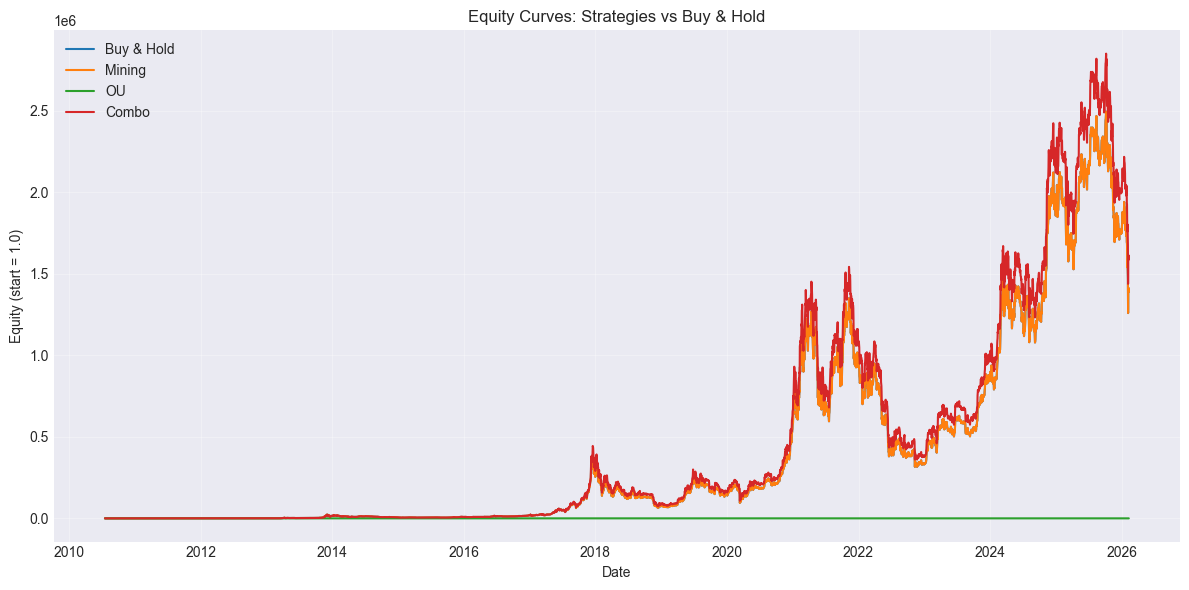

In [42]:
import matplotlib.pyplot as plt

curves = {
    "Buy & Hold": res_bh.equity,
    "Mining": res_mining.equity,
    "OU": res_ou.equity,
    "Combo": res_combo.equity,
}

plt.figure(figsize=(12, 6))
for name, eq in curves.items():
    plt.plot(eq.index, eq.values, label=name)

plt.title("Equity Curves: Strategies vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Equity (start = 1.0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
